In [3]:
# Hello World

In [4]:
import torch
import torchvision.transforms as T
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
from torch import tensor

In [5]:
# You can downlaod the dataset using: kaggle competitions download -c imagenet-object-localization-challenge

In [236]:
IMAGE_SIZE = 128
CENTER_SIZE = 64

# Utils

In [602]:
import math
def display_image(img):
        with torch.no_grad():
                img = img.permute((1, 2, 0))
                plt.imshow(img.cpu().numpy())
                plt.show()

def display_images(imgs, images_per_row=2):
        with torch.no_grad():
                rows = math.ceil(len(imgs) / images_per_row)
                plt.figure(figsize=(images_per_row*2, rows*2))
                for i, img in enumerate(imgs):
                        plt.subplot(rows, images_per_row, i+1)
                        plt.axis('off')
                        plt.tight_layout()
                        img = img.permute((1, 2, 0))
                        plt.imshow(img.cpu().numpy())
                plt.show()

def get_center_of_image(img, size=64):
        return T.CenterCrop((size, size))(img)

def get_img_without_center(img, size=64):
        left = (IMAGE_SIZE - CENTER_SIZE) // 2
        right = (IMAGE_SIZE - CENTER_SIZE) // 2 + CENTER_SIZE
        if(len(img.shape) == 3):
                img[ :, left:right, left:right ] = 0
        elif(len(img.shape) == 4):
                img[:, :, left:right, left:right ] = 0
        else:
                raise RuntimeError("Wrong shape to get_img_without_center!")
                
        return img

class CenterImageRemoval(object):
    def __init__(self, image_size, center_size):
        self.image_size = image_size
        self.center_size = center_size
        
    def __call__(self, img):
        left = (self.image_size - self.center_size) // 2
        right = (self.image_size - self.center_size) // 2 + self.center_size

        if(len(img.shape) == 3):
                assert img.shape[1] == img.shape[2] == self.image_size
                img[ :, left:right, left:right ] = 0
        elif(len(img.shape) == 4):
                assert img.shape[2] == img.shape[3] == self.image_size
                img[:, :, left:right, left:right ] = 0

        return img

class AddImageCenter(object):
    def __init__(self, image_size, center_size):
        self.image_size = image_size
        self.center_size = center_size
        
    def __call__(self, img, center):
        assert center.shape[1] == center.shape[2] == self.center_size

        left = (self.image_size - self.center_size) // 2
        right = (self.image_size - self.center_size) // 2 + self.center_size

        if(len(img.shape) == 3):
                assert img.shape[1] == img.shape[2] == self.image_size
                img[ :, left:right, left:right ] = center
        elif(len(img.shape) == 4):
                assert img.shape[2] == img.shape[3] == self.image_size
                img[:, :, left:right, left:right ] = center
        return img
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [555]:

sample_image = sample_batch[0][0]
sample_image = sample_image.float()

img_without_center = CenterImageRemoval(IMAGE_SIZE, CENTER_SIZE)(sample_image)


# Dataloading

In [556]:
train_tranforms = T.Compose([
    T.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    # T.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.RandomHorizontalFlip(p=0.5),
    CenterImageRemoval(IMAGE_SIZE, CENTER_SIZE),
    T.ConvertImageDtype(torch.float32),
])
gt_train_tranforms = T.Compose([
    T.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    # T.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.ConvertImageDtype(torch.float32),
])

# sanity_transforms = T.Compose([
#     T.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
#     T.CenterCrop(size=(IMAGE_SIZE, IMAGE_SIZE)),
#     T.ToTensor(),
#     T.ConvertImageDtype(torch.float32),
# ])

In [557]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np

class CustomDataSet(Dataset):
    def __init__(self, root_dir, classes, transform=None, ground_truth_transform=None, training_split=0.8, is_train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.ground_truth_transform = ground_truth_transform

        dirs = np.array(sorted(os.listdir(root_dir)))[classes]
        # print(dirs.shape)
        # train_split = int(dirs.shape[0]*training_split)
        # dirs = dirs[0:train_split]
        # print(dirs.shape)

        self.images = []

        for i, dir in enumerate(dirs):
            imgs = sorted(os.listdir(os.path.join(self.root_dir, dir)))
            train_split = int(len(imgs)*training_split)
            if is_train:
                imgs = imgs[0:train_split]
            else:
                imgs = imgs[train_split:]
            print(len(imgs))
            for img in imgs:
                self.images.append((os.path.join(self.root_dir, dir, img), classes[i]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name, class_label = self.images[idx]

        image = Image.open(img_name).convert('RGB')

        if self.transform:
            transformed_image = self.transform(image)
        else:
            transformed_image = image

        if self.ground_truth_transform:
            ground_truth_image = self.ground_truth_transform(image)
        else:
            ground_truth_image = image

        return transformed_image, ground_truth_image, class_label


# Create the dataset

# classes =  [538, 980]
classes =  [980]
DATASET_PATH = '/pub2/imagenet/ILSVRC/Data/CLS-LOC/train'
# Due to the way the dataset is strucutred, I can't use the offical validation images provided
# Therefore, I'm splitting the provided training_split from the dataset, 90% for training, and 10% for validation

train_dataset = CustomDataSet(root_dir=DATASET_PATH, 
                                      transform=train_tranforms, 
                                      ground_truth_transform=gt_train_tranforms,
                                      classes=classes,
                                      is_train=True,
                                      training_split=0.9
                                      )

validation_dataset = CustomDataSet(root_dir=DATASET_PATH, 
                                      transform=train_tranforms, 
                                      ground_truth_transform=gt_train_tranforms,
                                      classes=classes,
                                      is_train=False
                                      )

sanity_dataset = torch.utils.data.Subset(train_dataset, [1])


1170
260


In [558]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
sanity_loader = DataLoader(sanity_dataset, batch_size=1, shuffle=True)

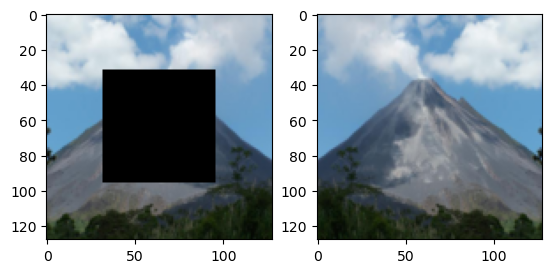

In [559]:
sample_batch = next(iter(train_loader))
sample_cutout, sample_gt, sample_class_idx = sample_batch

# sample_image = sample_batch[0][0]
# sample_image = sample_image.float()
# sample_image = sample_image.unsqueeze(0)
# print(sample_image.min(), sample_image.max())
display_images([sample_cutout[3], sample_gt[3]])
# plt.imshow(sample_cutout)

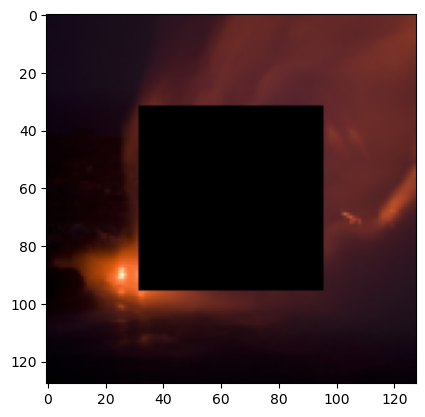

In [560]:
display_image(sample_image)
# for i in range(0, 10):
# 	display_image(sample_batch[0][i])
plt.show()

# Network

In [561]:
LATENT_SPACE_DIM = 4000
HIDDEN_LAYER_SIZE = 64

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # self.resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        # self.conv_t1 = nn.ConvTranspose2d(256, 64, kernel_size=(2, 2), stride=(2, 2), padding=0, output_padding=0 )
        # self.conv_1 = nn.Conv2d(128, 90, kernel_size=5, padding=1)
        # self.batch_norm_1 = nn.BatchNorm2d(90)
        # self.conv_2 = nn.Conv2d(90, 128, kernel_size=5, padding=1)
        # self.batch_norm_2 = nn.BatchNorm2d(128)
        # self.conv_t2 = nn.ConvTranspose2d(128, 3, kernel_size=5, stride=4, padding=0, output_padding=0 )
        # self.conv_final = nn.Conv2d(3, 3, 1)
        # self.num_classes = 5

        # (128, 128) -> (64, 64)
        self.conv1 = nn.Conv2d(3, HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)  

        # (64, 64) -> (32, 32)
        self.conv2 = nn.Conv2d(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)

        # (32, 32) -> (16, 16)
        self.conv3 = nn.Conv2d(HIDDEN_LAYER_SIZE, 2 * HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)  # 16x16 => 8x8

        # (16, 16) -> (8, 8)
        self.conv4 = nn.Conv2d(2 * HIDDEN_LAYER_SIZE, 4 * HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)

        # (8, 8) -> (4, 4)
        self.conv5 = nn.Conv2d(4 * HIDDEN_LAYER_SIZE, 8*HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)  # 8x8 => 4x4
        self.flatten = nn.Flatten()

        # (4, 4) -> (Latence_Space_Dim)
        self.linear = nn.Linear(4*4 * (8* HIDDEN_LAYER_SIZE), LATENT_SPACE_DIM)

    def forward(self, inp):
        # print(inp.shape)
        inp = F.leaky_relu(self.conv1(inp))
        # print(inp.shape)
        inp = F.leaky_relu(self.conv2(inp))
        # print(inp.shape)
        inp = F.leaky_relu(self.conv3(inp))
        # print(inp.shape)
        inp = F.leaky_relu(self.conv4(inp))
        # print(inp.shape)
        inp = F.leaky_relu(self.conv5(inp))
        inp = self.flatten(inp)

        # print(inp.shape)
        inp = F.leaky_relu(self.linear(inp))
        # Encoder
        # original_inp = inp
        # inp = self.resnet.conv1(inp)
        # inp = self.resnet.bn1(inp)
        # inp = self.resnet.relu(inp)
        # skip = inp.clone()
        # inp = self.resnet.maxpool(inp)
        # inp = self.resnet.layer1(inp)
        # inp = self.resnet.layer2(inp)
        # inp = self.resnet.layer3(inp)
        # inp = self.resnet.layer4(inp)
        # print("fully encoded shape is", inp.shape)
        return inp

In [562]:
encoder = Encoder()
encoder = encoder.to(device)
encoder(sample_image.to(device).unsqueeze(0)).shape
# # sample_untrained_out = try_running_image(sample_image, encoder, decoder)
# display_images([sample_untrained_out, sample_image])

torch.Size([1, 4000])

In [563]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # self.resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')

        # (LATENT_SPACE_DIM) -> (4 , 4)
        self.linear = nn.Linear(LATENT_SPACE_DIM, 4*4*8*HIDDEN_LAYER_SIZE)

        # (4, 4) -> (8 , 8)
        self.conv_t1 = nn.ConvTranspose2d(8*HIDDEN_LAYER_SIZE, 4*HIDDEN_LAYER_SIZE, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(4*HIDDEN_LAYER_SIZE)

        # (8, 8) -> (16, 16)
        self.conv_t2 = nn.ConvTranspose2d(4*HIDDEN_LAYER_SIZE, 2*HIDDEN_LAYER_SIZE , kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(2*HIDDEN_LAYER_SIZE)

        # (16, 16) -> (32, 32)
        self.conv_t3 = nn.ConvTranspose2d(2*HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(HIDDEN_LAYER_SIZE)

        # (32, 32) -> (64, 64)
        self.conv_t4 = nn.ConvTranspose2d(HIDDEN_LAYER_SIZE, 3, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        # self.batch_norm_4 = nn.BatchNorm2d(3)

        # self.conv = nn.Conv2d(HIDDEN_LAYER_SIZE, 3, kernel_size=4, stride=1, padding=1)
        # self.conv_t5 = nn.ConvTranspose2d(LATENT_SPACE_DIM // 64, 32, kernel_size=(2, 2), stride=(2, 2), padding=0, output_padding=1)
        # self.batch_norm_5 = nn.BatchNorm2d(32)

        # nn.Upsample(scale_factor = 2, mode='bilinear'),
        #                   nn.ReflectionPad2d(1),
        #                   nn.Conv2d(ngf * mult, int(ngf * mult / 2),
        #                                      kernel_size=3, stride=1, padding=0)



    def forward(self, inp):
        inp = self.linear(inp)
        # Reshape back to image size
        # inp.shape[0] gives the batch size
        # We want a 4x4 image shape 
        inp = inp.reshape(inp.shape[0], -1, 4, 4) 
        # print(inp.shape)

        inp = self.conv_t1(inp)
        inp = self.batch_norm_1(inp)
        inp = F.relu(inp)
        # print(inp.shape)

        inp = self.conv_t2(inp)
        inp = self.batch_norm_2(inp)
        inp = F.relu(inp)
        # print(inp.shape)

        inp = self.conv_t3(inp)
        inp = self.batch_norm_3(inp)
        inp = F.relu(inp)
        # print("here 1", inp.shape)

        inp = self.conv_t4(inp)
        # inp = self.batch_norm_4(inp)
        # inp = F.relu(inp)
        # print("here 2", inp.shape)

        # inp = self.conv_t5(inp)
        # inp = self.batch_norm_5(inp)
        # inp = F.relu(inp)
        # print(inp.shape)

        # inp = self.conv(inp)
        inp = torch.sigmoid(inp)
        
        # print("image size after decode is", inp.shape)
        # inp = T.Resize((IMAGE_SIZE, IMAGE_SIZE))(inp)

        return inp

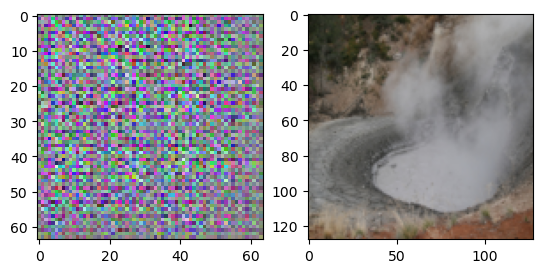

In [572]:
decoder = Decoder()
decoder = decoder.to(device)

sample_untrained_out = try_running_image(sample_cutout[0], encoder, decoder)
display_images([sample_untrained_out, sample_gt[0]])

In [565]:

def try_running_image(img, encoder, decoder):
	img = img.to(device)
	img = img.unsqueeze(0)
	embedding = encoder(img)
	out = decoder(embedding)[0]
	return out.cpu()

# Train  

In [566]:
from tqdm import tqdm

encoder = Encoder()
encoder = encoder.to(device)
decoder = Decoder()
decoder = decoder.to(device)

In [520]:
optim = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.01)
loss_fn = nn.MSELoss()

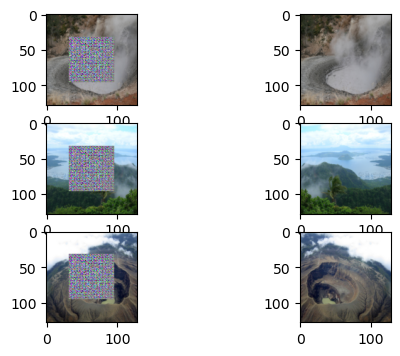

In [576]:
images = []

for sample_image_index in range(0,3):
	sample_untrained_out = try_running_image(sample_cutout[sample_image_index], encoder, decoder)
	with_center = AddImageCenter(IMAGE_SIZE, CENTER_SIZE)(torch.clone(sample_cutout[sample_image_index]), sample_untrained_out)
	images += [with_center, sample_gt[sample_image_index]]

display_images(images, images_per_row=2)


In [ ]:
EPOCHS = 500
for epcoh in range(EPOCHS):
	encoder.train()
	decoder.train()
	

	epoch_loss = 0
	total_number_of_images = len(train_loader)
	for index, batch in tqdm(enumerate(train_loader), total=total_number_of_images):
		data, _ = batch
		data = data.to(device)
		optim.zero_grad()

		embedded_images = encoder(data)
		decoded_images = decoder(embedded_images)


		loss = loss_fn(get_center_of_image(data), decoded_images)
		loss.backward()
		epoch_loss += loss.item()
		optim.step()
		display_images([decoded_images[0], get_center_of_image(data)[0]])
	print(f"Epoch Loss: {epoch_loss}")